In [17]:
InteractionsFileCaptureC='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/ChiCAGO_Calls_Adam/analysis/Chicago/CaptureC_SC_bait-bait.bed.gz'
#InteractionsFileHiC100='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE100.bed.gz'
#InteractionsFileHiC20='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE20.bed.gz'
#InteractionsFileHiC5='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE5.bed.gz'
PromoterFile='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/FIT-HI-C/promoters_flexible_repl_combined/data/reference_genomes/hg19/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
PROJDIR='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/kCCA'

In [18]:
features_path='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/peaks_at_promoters/output_thres5_max/'
atac=features_path+'atac.gz'
#TFs
ctcf=features_path+'CTCF.gz'
pol3=features_path+'PolII.gz'
TP63=features_path+'TP63.gz'
LSD1=features_path+'LSD1.gz'
#histone
H3K27ac=features_path+'H3K27ac.gz'
H3K27me3=features_path+'H3K27me3.gz'
H3K4me1=features_path+'H3K4me1.gz'
H3K4me3=features_path+'H3K4me3.gz'
H3K9ac=features_path+'H3K9ac.gz'

In [19]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
import testCrossValiFeatures as rcca
reload(rcca)

from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

In [20]:
# builds adjacency matrix 
def BuildMatrixA(PromoterFile, InteractionsFile, datatype):

    REFrag_dict={}
    index=0
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        key=(words[0], words[1], words[2])
        if words[0] in ['chr1']: # only chr1
           REFrag_dict[key]=index
           index+=1

    # Initialize matrix (promoter x promoter)
    PPMatrix=np.zeros((len(REFrag_dict), len(REFrag_dict))) #  number of promoters in chr 1

    # Fill (promoter x promoter) matrix with q-values of promoter-promoter interaction
    max_score=0
    for line in gzip.open(InteractionsFile,'r'):
        words=line.rstrip().split()
            
    for line in gzip.open(InteractionsFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: #only chr1
            i=REFrag_dict[(words[0], words[1], words[2])]
            j=REFrag_dict[(words[3], words[4], words[5])]


            q_values=float(words[6])  # for CaptureC
            if PPMatrix[i,j] != 0:
                PPMatrix[i,j]=PPMatrix[i,j]/2+q_values/2
                PPMatrix[j,i]=PPMatrix[j,i]/2+q_values/2
            else:
                PPMatrix[i,j]=q_values
                PPMatrix[j,i]=q_values
                    # take -1*log(Q) for non-zero entries
    #mask = PPMatrix != 0
    #PPMatrix[mask] = np.log10(PPMatrix[mask])*(-1)

    # list of non-zero q-values
    q_values=list(filter((0.0).__ne__,list(itertools.chain.from_iterable(np.array(PPMatrix).tolist()))))

    # Some tests:
    print "Some tests on adjacency matrix:"
    # 1. Check if the matrix is symmetric:
    if (PPMatrix.transpose() == PPMatrix).all() == True:
        print "Adjacency matrix is symmetric"
    # 2. Print out average q-values:
    print "Average q-value with zeros: ", str(np.average(PPMatrix))
    print "Average q-value w/o zeros: ", np.mean(q_values)

    # Print distribution of q-values
    plt.hist(q_values)
    plt.show()

    return PPMatrix

In [21]:
def printMatrix(Matrix, ylabel, QuantileValue, LowerUpperLimit, title=''):
    #vmaxLim=mquantiles(Matrix,[0.99])[0]
    Lim=mquantiles(Matrix,[QuantileValue])[0]
    print Matrix.max()
    print np.shape(Matrix)
    print "Limit:", Lim
    fig, ax = plt.subplots()
    fig.subplots_adjust(top=0.8)
    if LowerUpperLimit == 'lower':
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmin=Lim)
    else:
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmax=Lim) # cmap="RdYlBu_r"


    ax.axhline(-0.5, color="#000000", linewidth=1, linestyle="--")
    ax.axvline(-0.5, color="#000000", linewidth=1, linestyle="--")

    cb = fig.colorbar(m)
    cb.set_label(ylabel)

    ax.set_ylim((-0.5, len(Matrix) - 0.5))
    ax.set_xlim((-0.5, len(Matrix) - 0.5))
    
    plt.title(title)
    plt.show()
    return


In [22]:
# builds feature vector 
def BuildFeatureVector(PromoterFile, FeatureVectorFile, dataName):

    REFrag_dict={}
    index=0
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        key=(words[0], words[1], words[2])
        if words[0] in ['chr1']: # only chr1
           REFrag_dict[key]=index
           index+=1

    # Initialize vector (promoters only)
    vector=np.zeros((len(REFrag_dict),)) #  number of promoters in chr 1

    for line in gzip.open(FeatureVectorFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: #only chr1
            value=words[3]
            i=REFrag_dict[(words[0], words[1], words[2])]
            vector[i]=value

    # list of non-zero q-values
    nonzero_values=filter(lambda a: a != 0, np.array(vector).reshape(-1,).tolist())

    # Print out average q-values:
    print "Average value with zeros: ", str(np.average(vector))
    print "Average q-value w/o zeros: ", np.mean(nonzero_values)

    # Print distribution of q-values
    plt.hist(vector)
    plt.title(str(dataName))
    plt.show()

    return vector

In [23]:
def set_diag_to_value(matrix, value):
    np.fill_diagonal(matrix, value)
    return matrix

In [24]:
def binarize(matrix, thres=0):
    copy.copy(matrix)
    matrix[matrix <= thres] = 0
    matrix[matrix > thres] = 1    
    return matrix

In [25]:
def demean(d): return d-d.mean(0) 
def zscore(d): return (d-d.mean(0))/d.std(0)

In [87]:
#test proportion is computed as total-train
def shuffle_nodes (vector_1d, trainProportion, valiProportion):
    total_num=len(vector_1d)
    train_num=int(trainProportion*total_num)
    vali_num=int(valiProportion*total_num)
    test_num=total_num-train_num-vali_num
    if test_num<=0:
        print "Nothing in the test set!!!"
    print "Training set: "+str(train_num)
    print "Validation set: "+str(vali_num)
    print "Test set: "+str(test_num)
    #decide the random split of nodes
    nodes=[i for i in range(len(vector_1d))]
    shuffled_nodes=copy.copy(nodes)
    random.shuffle(shuffled_nodes)
    train_nodes=np.array(shuffled_nodes[:train_num])
    vali_nodes=np.array(shuffled_nodes[train_num:train_num+vali_num])
    test_nodes=np.array(shuffled_nodes[train_num+vali_num:])
    return train_nodes, vali_nodes, test_nodes
# shuffle and split nodes 
def train_vali_test(data_3d, labels_1d, indx_2d, trainProportion, valiProportion):
    train_nodes, vali_nodes, test_nodes = shuffle_nodes(labels_1d, trainProportion, valiProportion)
    train_set=data_3d[train_nodes, :, :]
    vali_set=data_3d[vali_nodes, :, :]
    test_set=data_3d[test_nodes, :, :]
    labels_train=labels_1d[train_nodes]
    labels_vali=labels_1d[vali_nodes]
    labels_test=labels_1d[test_nodes]
    indx_train=indx_2d[train_nodes,:]
    indx_vali=indx_2d[vali_nodes,:]
    indx_test=indx_2d[test_nodes,:]
    
    #train_by_train=PPMatrix[shuffled_nodes[0]][:,shuffled_nodes[0]]
    #print "Train by train:", np.shape(train_by_train), "Test by train:", np.shape(test_by_train), "Test by test:", np.shape(test_by_test), "All by train:", np.shape(all_by_train), "All by all:", np.shape(all_by_all) 
    return train_set, vali_set, test_set, labels_train, labels_vali, labels_test, indx_train, indx_vali,  indx_test

In [27]:
def build_distance_for_node(PromoterFile): 
    REsiteMids=[]
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: # only chr1
            REsiteMids.append((int(words[2])+int(words[1]))/2)
    return np.array((REsiteMids))

Some tests on adjacency matrix:
Adjacency matrix is symmetric
Average q-value with zeros:  0.013635616418
Average q-value w/o zeros:  1.58521764289


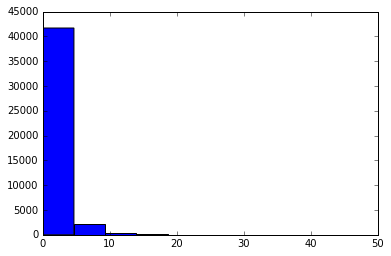

In [28]:
CaptureC = BuildMatrixA(PromoterFile, InteractionsFileCaptureC, 'CaptureC')

In [29]:
CaptureC_labels=binarize(set_diag_to_value(CaptureC, CaptureC.max()))

1.0
(2272, 2272)
Limit: 1.0


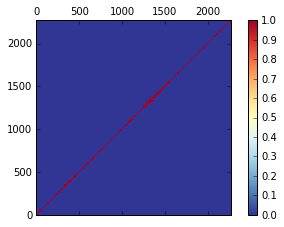

In [30]:
printMatrix(CaptureC_labels, '', 1, 1, title='')

1.0
(100, 100)
Limit: 1.0


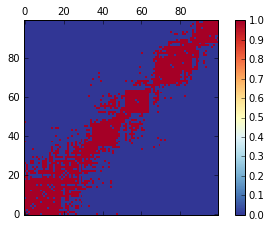

In [31]:
subset=CaptureC_labels[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


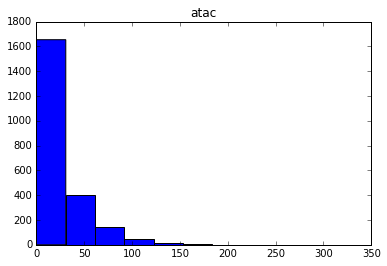

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


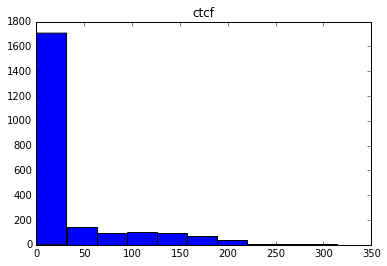

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


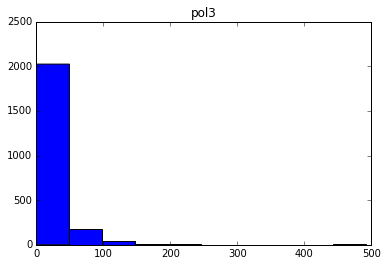

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


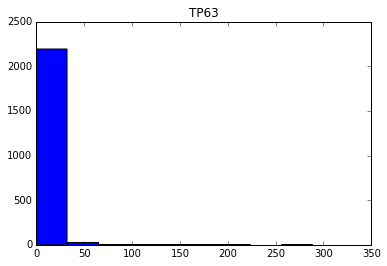

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


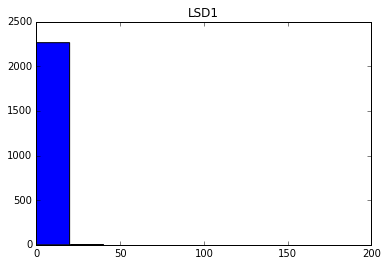

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


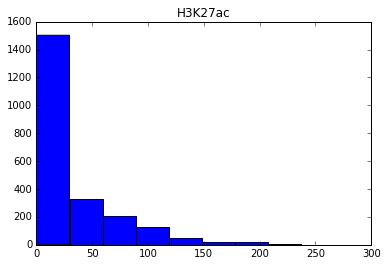

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


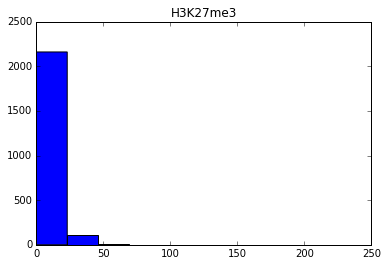

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


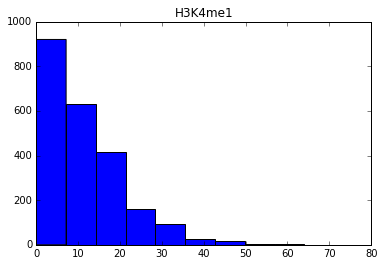

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


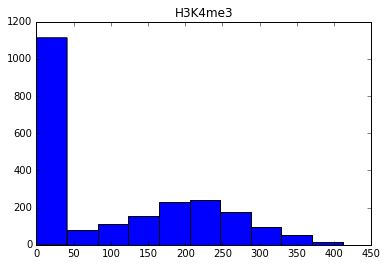

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


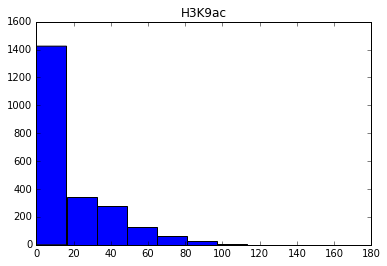

In [32]:
VectorATAC=BuildFeatureVector(PromoterFile, atac, 'atac')

VectorCTCF=BuildFeatureVector(PromoterFile, ctcf, 'ctcf')
VectorPOL3=BuildFeatureVector(PromoterFile, pol3, 'pol3')
VectorTP63=BuildFeatureVector(PromoterFile, TP63, 'TP63')
VectorLSD1=BuildFeatureVector(PromoterFile, LSD1, 'LSD1')

VectorH3K27ac=BuildFeatureVector(PromoterFile, H3K27ac, 'H3K27ac')
VectorH3K27me3=BuildFeatureVector(PromoterFile, H3K27me3, 'H3K27me3')
VectorH3K4me1=BuildFeatureVector(PromoterFile, H3K4me1, 'H3K4me1')
VectorH3K4me3=BuildFeatureVector(PromoterFile, H3K4me3, 'H3K4me3')
VectorH3K9ac=BuildFeatureVector(PromoterFile, H3K9ac, 'H3K9ac')

In [33]:
distance_for_node=build_distance_for_node(PromoterFile)

In [34]:
FeatureVector = np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac)).T
FeatureVectorDistance = np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T

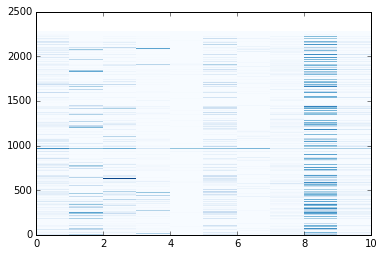

In [35]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector, cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

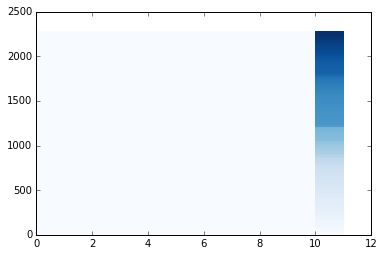

In [36]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVectorDistance, cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

# All Data

In [88]:
NumberOfNodes=CaptureC_labels.shape[0]
labels_all=np.zeros((NumberOfNodes**2,1))
indx_all=np.zeros((NumberOfNodes**2,2))
data_all=np.zeros((NumberOfNodes**2,11,2))
k1=0
for i in range(NumberOfNodes):
    for j in range(NumberOfNodes):
        labels_all[k1]=CaptureC_labels[i][j]
        data_all[k1,:,0]=FeatureVectorDistance[i,:]
        data_all[k1,:,1]=FeatureVectorDistance[j,:]
        indx_all[k1,0]=int(i)
        indx_all[k1,1]=int(j)
        k1+=1

In [92]:
train_set_all, vali_set_all, test_set_all, labels_train_all, labels_vali_all, labels_test_all,  indx_train_all, indx_vali_all,  indx_test_all =train_vali_test(data_all, labels_all, indx_all, 0.5, 0.3)

Training set: 2580992
Validation set: 1548595
Test set: 1032397


In [94]:
print labels_all.shape
print indx_all.shape
print data_all.shape
print labels_train_all.shape
print indx_train_all.shape
print train_set_all.shape

(5161984, 1)
(5161984, 2)
(5161984, 11, 2)
(2580992, 1)
(2580992, 2)
(2580992, 11, 2)


# Upper Triangle

In [95]:
NumberOfNodes=CaptureC_labels.shape[0]
labels_upperTriangle=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2))
indx_upperTriangle=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,2))
data_upperTriangle=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,11,2))
k1=0
for i in range(NumberOfNodes):
    for j in range(i+1):
        labels_upperTriangle[k1]=CaptureC_labels[i][j]
        data_upperTriangle[k1,:,0]=FeatureVectorDistance[i,:]
        data_upperTriangle[k1,:,1]=FeatureVectorDistance[j,:]
        indx_upperTriangle[k1,0]=int(i)
        indx_upperTriangle[k1,1]=int(j)
        k1+=1

In [97]:
train_set_upperTriangle, vali_set_upperTriangle, test_set_upperTriangle, labels_train_upperTriangle, labels_vali_upperTriangle, labels_test_upperTriangle, indx_train_upperTriangle, indx_vali_upperTriangle,  indx_test_upperTriangle = train_vali_test(data_upperTriangle, labels_upperTriangle, indx_upperTriangle, 0.5, 0.3)

Training set: 1291064
Validation set: 774638
Test set: 516426


In [98]:
print labels_upperTriangle.shape
print indx_upperTriangle.shape
print data_upperTriangle.shape
print labels_train_upperTriangle.shape
print indx_train_upperTriangle.shape
print train_set_upperTriangle.shape

(2582128,)
(2582128, 2)
(2582128, 11, 2)
(1291064,)
(1291064, 2)
(1291064, 11, 2)


# Upper Triangle without Diagonal

In [99]:
NumberOfNodes=CaptureC_labels.shape[0]
labels_upperTriangle_noDiag=np.zeros(((NumberOfNodes**2-NumberOfNodes)/2))
indx_upperTriangle_noDiag=np.zeros(((NumberOfNodes**2-NumberOfNodes)/2,2))
data_upperTriangle_noDiag=np.zeros(((NumberOfNodes**2-NumberOfNodes)/2,11,2))
k1=0
for i in range(NumberOfNodes):
    for j in range(i+1):
        if i!=j:
            labels_upperTriangle_noDiag[k1]=CaptureC_labels[i][j]
            data_upperTriangle_noDiag[k1,:,0]=FeatureVectorDistance[i,:]
            data_upperTriangle_noDiag[k1,:,1]=FeatureVectorDistance[j,:]
            indx_upperTriangle_noDiag[k1,0]=int(i)
            indx_upperTriangle_noDiag[k1,1]=int(j)
            k1+=1

In [100]:
train_set_upperTriangle_noDiag, vali_set_upperTriangle_noDiag, test_set_upperTriangle_noDiag, labels_train_upperTriangle_noDiag, labels_vali_upperTriangle_noDiag, labels_test_upperTriangle_noDiag, indx_train_upperTriangle_noDiag, indx_vali_upperTriangle_noDiag,  indx_test_upperTriangle_noDiag =train_vali_test(data_upperTriangle_noDiag, labels_upperTriangle_noDiag, indx_upperTriangle_noDiag, 0.5, 0.3)

Training set: 1289928
Validation set: 773956
Test set: 515972


In [103]:
print np.sum(labels_train_upperTriangle_noDiag==1)
print np.sum(labels_train_upperTriangle_noDiag==0)
print np.sum(labels_train_upperTriangle==1)
print np.sum(labels_train_upperTriangle==0)
print np.sum(labels_train_all==1)
print np.sum(labels_train_all==0)

11154
1278774
12291
1278773
23360
2557632


In [46]:
#np.save('train_set_all_thres2_mean.npy', train_set_all) 
#np.save('vali_set_all_thres2_mean.npy', vali_set_all) 
#np.save('test_set_all_thres2_mean.npy', test_set_all) 
#np.save('labels_train_all_thres2_mean.npy', labels_train_all)
#np.save('labels_vali_all_thres2_mean.npy', labels_vali_all)
#np.save('labels_test_all_thres2_mean.npy', labels_test_all)

#np.save('train_set_upperTriangle.npy', train_set_upperTriangle) 
#np.save('vali_set_upperTriangle.npy', vali_set_upperTriangle) 
#np.save('test_set_upperTriangle.npy', test_set_upperTriangle) 
#np.save('labels_train_upperTriangle.npy', labels_train_upperTriangle)
#np.save('labels_vali_upperTriangle.npy', labels_vali_upperTriangle)
#np.save('labels_test_upperTriangle.npy', labels_test_upperTriangle)
#d = np.load('labels_test_all.npy')